=== オーグメンテーションなし ===


<Figure size 500x500 with 0 Axes>

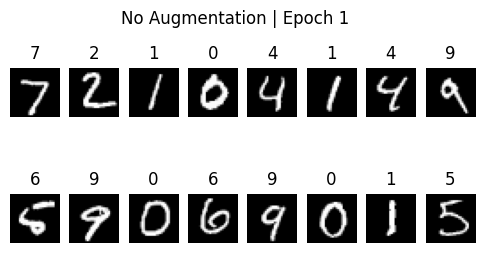

No Augmentation Epoch 1: TrainLoss=0.300, TestAcc=0.956
No Augmentation Epoch 2: TrainLoss=0.126, TestAcc=0.971
No Augmentation Epoch 3: TrainLoss=0.085, TestAcc=0.974
No Augmentation Epoch 4: TrainLoss=0.062, TestAcc=0.974


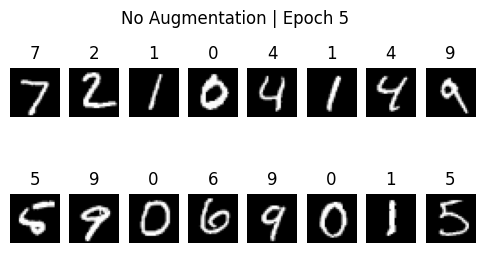

No Augmentation Epoch 5: TrainLoss=0.047, TestAcc=0.977
No Augmentation Epoch 6: TrainLoss=0.037, TestAcc=0.979
No Augmentation Epoch 7: TrainLoss=0.028, TestAcc=0.979
No Augmentation Epoch 8: TrainLoss=0.021, TestAcc=0.978
No Augmentation Epoch 9: TrainLoss=0.017, TestAcc=0.978


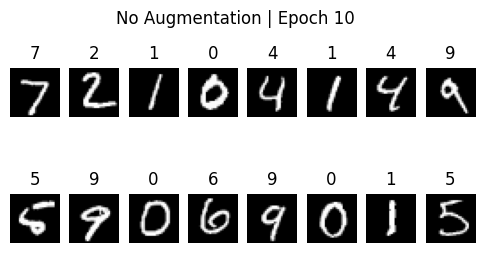

No Augmentation Epoch 10: TrainLoss=0.015, TestAcc=0.978


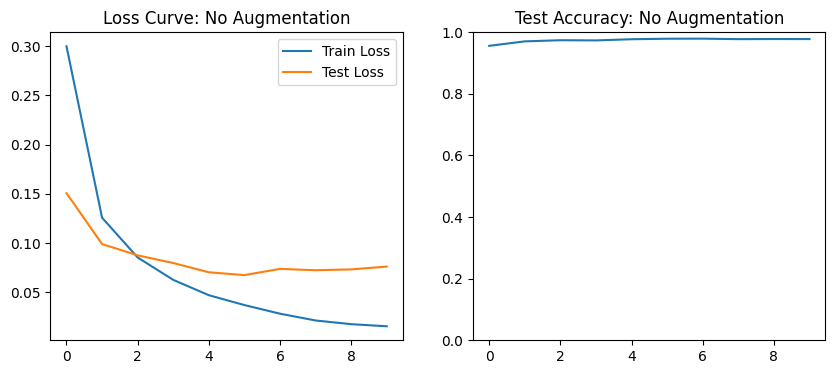

=== オーグメンテーションあり ===


<Figure size 500x500 with 0 Axes>

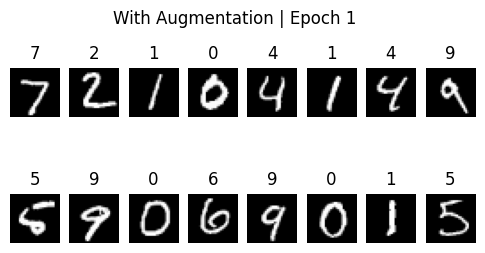

With Augmentation Epoch 1: TrainLoss=0.750, TestAcc=0.945
With Augmentation Epoch 2: TrainLoss=0.336, TestAcc=0.962
With Augmentation Epoch 3: TrainLoss=0.273, TestAcc=0.965
With Augmentation Epoch 4: TrainLoss=0.239, TestAcc=0.970


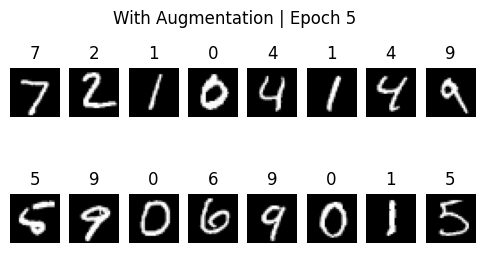

With Augmentation Epoch 5: TrainLoss=0.216, TestAcc=0.972
With Augmentation Epoch 6: TrainLoss=0.204, TestAcc=0.975
With Augmentation Epoch 7: TrainLoss=0.194, TestAcc=0.979
With Augmentation Epoch 8: TrainLoss=0.180, TestAcc=0.976
With Augmentation Epoch 9: TrainLoss=0.177, TestAcc=0.978


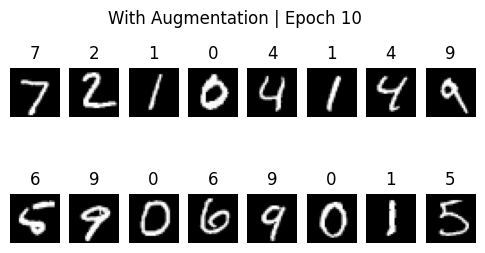

With Augmentation Epoch 10: TrainLoss=0.169, TestAcc=0.979


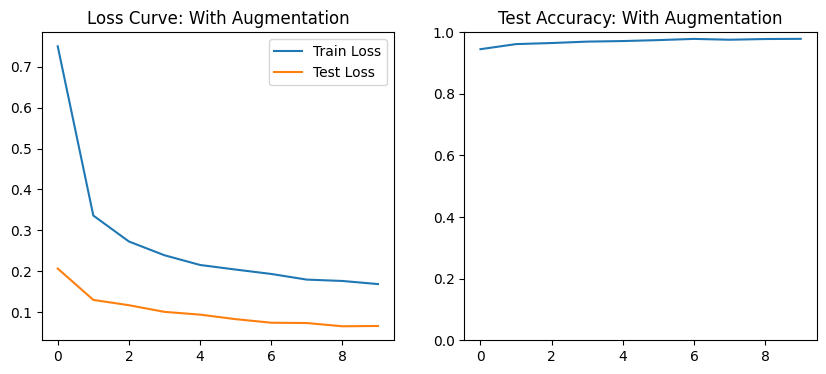

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ======================
# データオーグメンテーション設定
# ======================
transform_no_aug = transforms.ToTensor()

transform_aug = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
])

# ======================
# MNIST データロード
# ======================
train_no_aug = datasets.MNIST(root="./data", train=True, download=True, transform=transform_no_aug)
train_aug = datasets.MNIST(root="./data", train=True, download=True, transform=transform_aug)

test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

train_loader_no_aug = DataLoader(train_no_aug, batch_size=64, shuffle=True)
train_loader_aug = DataLoader(train_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# ======================
# シンプルなMLPモデル
# ======================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.net(x)

# ======================
# 評価関数
# ======================
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for x,y in loader:
            pred = model(x)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

# ======================
# 学習＋可視化
# ======================
def train_and_plot(train_loader, title=""):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_list = []
    test_loss_list = []
    test_acc_list = []

    plt.figure(figsize=(5,5))

    for epoch in range(1, 11):
        model.train()
        total_loss = 0

        for x,y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        test_loss, test_acc = evaluate(model, test_loader)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        # ---- 中間画像可視化 ----
        if epoch in [1, 5, 10]:
            x, _ = next(iter(test_loader))
            with torch.no_grad():
                out = model(x[:16]).argmax(dim=1)

            plt.figure(figsize=(6,3))
            for i in range(16):
                plt.subplot(2,8,i+1)
                plt.imshow(x[i].squeeze(), cmap="gray")
                plt.title(f"{out[i].item()}")
                plt.axis("off")
            plt.suptitle(f"{title} | Epoch {epoch}")
            plt.show()

        print(f"{title} Epoch {epoch}: TrainLoss={train_loss:.3f}, TestAcc={test_acc:.3f}")

    # ---- 学習曲線可視化 ----
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(train_loss_list, label="Train Loss")
    plt.plot(test_loss_list, label="Test Loss")
    plt.title(f"Loss Curve: {title}")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(test_acc_list)
    plt.title(f"Test Accuracy: {title}")
    plt.ylim(0, 1)

    plt.show()

    return train_loss_list, test_loss_list


# ======================
# 実行
# ======================
print("=== オーグメンテーションなし ===")
train_loss_list_without_da, test_loss_list_without_da = train_and_plot(train_loader_no_aug, title="No Augmentation")

print("=== オーグメンテーションあり ===")
train_loss_list_with_da, test_loss_list_with_da = train_and_plot(train_loader_aug, title="With Augmentation")


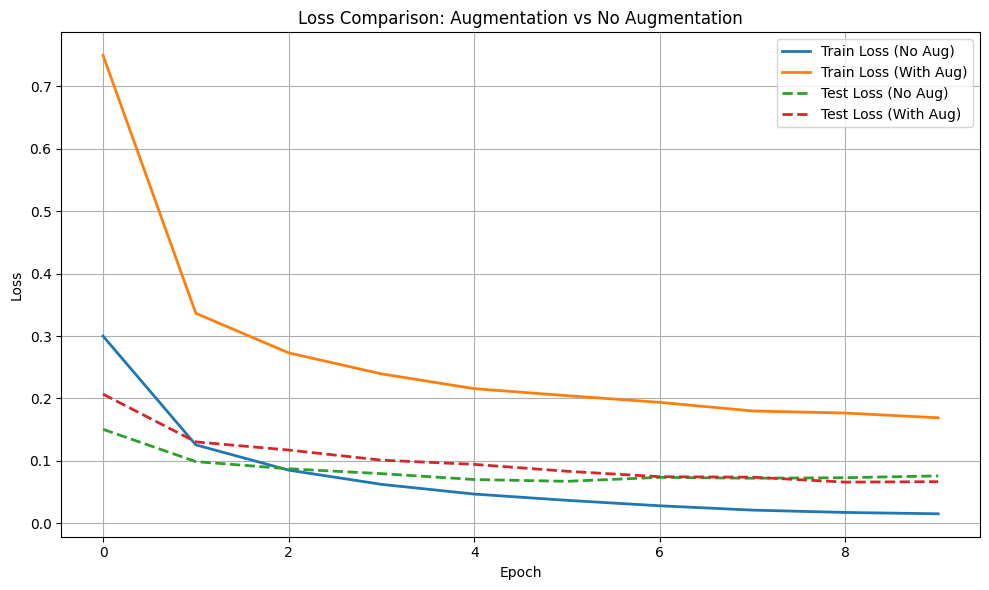

In [4]:
def plot_loss_comparison(
    train_loss_without, test_loss_without,
    train_loss_with, test_loss_with
):
    plt.figure(figsize=(10,6))

    # --- Train Loss ---
    plt.plot(train_loss_without, label="Train Loss (No Aug)", linewidth=2)
    plt.plot(train_loss_with, label="Train Loss (With Aug)", linewidth=2)

    # --- Test Loss ---
    plt.plot(test_loss_without, label="Test Loss (No Aug)", linestyle="--", linewidth=2)
    plt.plot(test_loss_with, label="Test Loss (With Aug)", linestyle="--", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Comparison: Augmentation vs No Augmentation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ===== 実際の呼び出し =====

plot_loss_comparison(
    train_loss_list_without_da, test_loss_list_without_da,
    train_loss_list_with_da, test_loss_list_with_da
)